In [1]:
# Import the libraries
import pandas as pd
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# import the dateset
df_ = pd.read_excel('/kaggle/input/uci-online-retail-ii-data-set/online_retail_II.xlsx', sheet_name='Year 2009-2010')
df_.columns = [col.lower() for col in df_.columns]
df = df_.copy()
df.head()

invoice stockcode                          description  quantity         invoicedate  price  customer id         country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00  6.950    13085.000  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00  6.750    13085.000  United Kingdom
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00  6.750    13085.000  United Kingdom
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00  2.100    13085.000  United Kingdom
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24 2009-12-01 07:45:00  1.250    13085.000  United Kingdom

In [3]:
# get the unique number of product
df['description'].nunique()

4681

In [4]:
# get the frequence of each product
df['description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     3549
REGENCY CAKESTAND 3 TIER               2212
STRAWBERRY CERAMIC TRINKET BOX         1843
PACK OF 72 RETRO SPOT CAKE CASES       1466
ASSORTED COLOUR BIRD ORNAMENT          1457
                                       ... 
stock credited from royal yacht inc       1
VINTAGE METAL CAKE STAND CREAM            1
BLUE BAROQUE FLOCK CANDLE HOLDER          1
S/4 HEART CRYSTAL FRIDGE MAGNETS          1
dotcom email                              1
Name: description, Length: 4681, dtype: int64

In [5]:
# get how many each product were sold in total
df.groupby('description').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False).head()

quantity
description                                 
WHITE HANGING HEART T-LIGHT HOLDER     57733
WORLD WAR 2 GLIDERS ASSTD DESIGNS      54698
BROCADE RING PURSE                     47647
PACK OF 72 RETRO SPOT CAKE CASES       46106
ASSORTED COLOUR BIRD ORNAMENT          44925

In [6]:
# get the unique number of invoices
df['invoice'].nunique()

28816

In [7]:
# add a new variable named total_price as a response
df['total_price'] = df['quantity'] * df['price']
df.sort_values(by='total_price', ascending=False).head()

invoice  stockcode                          description  quantity         invoicedate     price  customer id         country  total_price
241827  512771          M                               Manual         1 2010-06-17 16:53:00 25111.090          NaN  United Kingdom    25111.090
432176  530715      84347  ROTATING SILVER ANGELS T-LIGHT HLDR      9360 2010-11-04 11:36:00     1.690    15838.000  United Kingdom    15818.400
517955  537632  AMAZONFEE                           AMAZON FEE         1 2010-12-07 15:08:00 13541.330          NaN  United Kingdom    13541.330
135013  502263          M                               Manual         1 2010-03-23 15:22:00 10953.500    12918.000  United Kingdom    10953.500
135015  502265          M                               Manual         1 2010-03-23 15:28:00 10953.500          NaN  United Kingdom    10953.500

In [8]:
# get the total price paid per each invoice
df.groupby('invoice').agg({'total_price': 'sum'}).head().sort_values(by='total_price', ascending=False)

total_price
invoice             
489438      2286.240
489436       630.330
489434       505.300
489437       310.750
489435       145.800

In [9]:
# preparation of the dataset

# get the missing data
df.isnull().sum()

invoice             0
stockcode           0
description      2928
quantity            0
invoicedate         0
price               0
customer id    107927
country             0
total_price         0
dtype: int64

In [10]:
# delete the missing data
df.dropna(inplace=True)

In [11]:
# get the invoices containing the 'C', which refers the returns
df[df['invoice'].str.contains('C', na=False)]

invoice stockcode                       description  quantity         invoicedate  price  customer id         country  total_price
178     C489449     22087          PAPER BUNTING WHITE LACE       -12 2009-12-01 10:33:00  2.950    16321.000       Australia      -35.400
179     C489449    85206A      CREAM FELT EASTER EGG BASKET        -6 2009-12-01 10:33:00  1.650    16321.000       Australia       -9.900
180     C489449     21895     POTTING SHED SOW 'N' GROW SET        -4 2009-12-01 10:33:00  4.250    16321.000       Australia      -17.000
181     C489449     21896                POTTING SHED TWINE        -6 2009-12-01 10:33:00  2.100    16321.000       Australia      -12.600
182     C489449     22083        PAPER CHAIN KIT RETRO SPOT       -12 2009-12-01 10:33:00  2.950    16321.000       Australia      -35.400
...         ...       ...                               ...       ...                 ...    ...          ...             ...          ...
524695  C538123     22956          36 FOIL HEART CAKE CASES        -2 2010-12-09 15:41:00  2.100    12605.000         Germany       -4.200
524696  C538124         M                            Manual        -4 2010-12-09 15:43:00  0.500    15329.000  United Kingdom       -2.000
524697  C538124     22699  ROSES REGENCY TEACUP AND SAUCER         -1 2010-12-09 15:43:00  2.950    15329.000  United Kingdom       -2.950
524698  C538124     22423          REGENCY CAKESTAND 3 TIER        -1 2010-12-09 15:43:00 12.750    15329.000  United Kingdom      -12.750
525282  C538164    35004B       SET OF 3 BLACK FLYING DUCKS        -1 2010-12-09 17:32:00  1.950    14031.000  United Kingdom       -1.950

[9839 rows x 9 columns]

In [12]:
# delete the invoices containing the 'C', which refers the returns and assign it to the dataframe
df = df[~df['invoice'].str.contains('C', na=False)]
df.shape

(407695, 9)

In [13]:
# price must be higher than zero
df = df[df['price'] > 0]

In [14]:
# understanding the dataframe
def check_dataframe(dataframe):
    print('####################################')
    print(dataframe.head())
    print('####################################')
    print(dataframe.tail())
    print('####################################')
    print(dataframe.shape)
    print('####################################')
    print(dataframe.columns)
    print('####################################')
    print(dataframe.info())
    print('####################################')
    print(dataframe.isnull().values.any())
    print('####################################')
    print(dataframe.isnull().sum())
    print('####################################')
    print(dataframe.nunique())
    print('####################################')
    print(dataframe.describe([0.05, 0.1, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T)

check_dataframe(df)

####################################
  invoice stockcode                          description  quantity         invoicedate  price  customer id         country  total_price
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00  6.950    13085.000  United Kingdom       83.400
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00  6.750    13085.000  United Kingdom       81.000
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00  6.750    13085.000  United Kingdom       81.000
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00  2.100    13085.000  United Kingdom      100.800
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24 2009-12-01 07:45:00  1.250    13085.000  United Kingdom       30.000
####################################
       invoice stockcode                         description  quantity         invoicedate  price  customer id

In [15]:
# understanding the dataframe
# grabing categorical, numerical, and cardinal variables
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # categorical variable
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # numerical variables
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # reposrting section
    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # keeping the calculated values
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 407664
Variables: 9
cat_cols: 0
num_cols: 5
cat_but_car: 4
num_but_cat: 0


In [16]:
num_cols = [col for col in num_cols if 'invoicedate' not in col]
num_cols

['quantity', 'price', 'customer id', 'total_price']

In [17]:
# summary of numerical variables
def num_summary(dataframe, numerical_col, plot=False):
    print('\n', '#' * 10, numerical_col.upper(), '#' * 10)
    print(pd.DataFrame({
        numerical_col.upper(): round(dataframe[numerical_col].describe().T, 2)
    }))

    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(y=dataframe[numerical_col])
        plt.ylabel(numerical_col.upper())
        plt.subplot(1, 2, 2)
        sns.histplot(x=dataframe[numerical_col])
        plt.xlabel(numerical_col.upper())
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=False)


 ########## QUANTITY ##########
        QUANTITY
count 407664.000
mean      13.590
std       96.840
min        1.000
25%        2.000
50%        5.000
75%       12.000
max    19152.000

 ########## PRICE ##########
           PRICE
count 407664.000
mean       3.290
std       34.760
min        0.000
25%        1.250
50%        1.950
75%        3.750
max    10953.500

 ########## CUSTOMER ID ##########
       CUSTOMER ID
count   407664.000
mean     15368.590
std       1679.760
min      12346.000
25%      13997.000
50%      15321.000
75%      16812.000
max      18287.000

 ########## TOTAL_PRICE ##########
       TOTAL_PRICE
count   407664.000
mean        21.660
std         77.150
min          0.000
25%          4.950
50%         11.900
75%         19.500
max      15818.400


In [18]:
# analyzing the numerical columns with dependent variable
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n")

    if plot:
        sns.barplot(x=dataframe[target], y=dataframe[numerical_col])
        plt.ylabel(numerical_col.upper())
        plt.xlabel(target.upper())
        plt.show(block=True)

num_cols = [col for col in num_cols if col not in ['total_price', 'customer id']]
for col in num_cols:
    target_summary_with_num(df, 'total_price', col, plot=False)

             quantity
total_price          
0.001           1.000
0.060           1.000
0.100           1.000
0.120           1.000
0.140           1.000
...               ...
8925.000     3500.000
8985.600        1.000
10468.800       1.000
10953.500       1.000
15818.400    9360.000

[2529 rows x 1 columns]

                price
total_price          
0.001           0.001
0.060           0.060
0.100           0.100
0.120           0.120
0.140           0.140
...               ...
8925.000        2.550
8985.600     8985.600
10468.800   10468.800
10953.500   10953.500
15818.400       1.690

[2529 rows x 1 columns]



# **CUSTOMER SEGMENTATION WITH RFM ANALYSIS**
### Calculation of rfm metrics (recency, frequency, and monetary)
* recency = date of analysis - purchase date of the relevant customer
* frequency = customer's total number of purchases
* monetary = total monetary value as a result of the customer's total purchases

In [19]:
# get the last invoice date in the dataset
df['invoicedate'].max() # Timestamp('2010-12-09 20:01:00')

Timestamp('2010-12-09 20:01:00')

In [20]:
# adding 2 days to the calculated last data
today_date = dt.datetime(2010, 12, 11)

In [21]:
# get the type of the today_data
type(today_date)    # <class 'datetime.datetime'>

datetime.datetime

In [22]:
# the base of the rfm analysis is a simple pandas operation
# in the 'customer id' breakdown, get a groupby() proces and calculate the r, f, and m values
rfm = df.groupby('customer id').agg({
    'invoicedate': lambda x: (today_date - x.max()).days,
    'invoice': lambda x: x.nunique(),
    'total_price': lambda x: x.sum()})
rfm.head()

invoicedate  invoice  total_price
customer id                                   
12346.000            165       11      372.860
12347.000              3        2     1323.320
12348.000             74        1      222.160
12349.000             43        3     2671.140
12351.000             11        1      300.930

In [23]:
# change the column names
rfm.columns = ['recency', 'frequency', 'monetary']
rfm.head()

recency  frequency  monetary
customer id                              
12346.000        165         11   372.860
12347.000          3          2  1323.320
12348.000         74          1   222.160
12349.000         43          3  2671.140
12351.000         11          1   300.930

In [24]:
# get the descriptive statistics
rfm.describe().T

count     mean      std   min     25%     50%      75%        max
recency   4312.000   91.173   96.861 1.000  18.000  53.000  136.000    374.000
frequency 4312.000    4.456    8.170 1.000   1.000   2.000    5.000    205.000
monetary  4312.000 2048.238 8914.481 2.950 307.988 706.020 1723.142 349164.350

In [25]:
# delete the null values from the monetary values since its value can not be null
rfm = rfm[rfm['monetary'] > 0]
rfm.head()

recency  frequency  monetary
customer id                              
12346.000        165         11   372.860
12347.000          3          2  1323.320
12348.000         74          1   222.160
12349.000         43          3  2671.140
12351.000         11          1   300.930

In [26]:
# calculation the rfm scores

# convert the recency values to scores
rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
# normally, the the best recency value is one, but after converting the best recency score is 5

# convert the monetary values to scores
rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

# convert the frequency values to scores
rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
# when rank(method='first') is not used, it gives a ValueError. because, there are many repeated frequence values
# and when ordering small to big, the values in the quantiles were the same. to solve this, rank method was used.
# when this method was used, assign the first seen value to the first class

In [27]:
# after this stage, by using the R and F values, the scores can be formed.
rfm['rfm_score'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)
rfm.head()

recency  frequency  monetary recency_score monetary_score frequency_score rfm_score
customer id                                                                                     
12346.000        165         11   372.860             2              2               5        25
12347.000          3          2  1323.320             5              4               2        52
12348.000         74          1   222.160             2              1               1        21
12349.000         43          3  2671.140             3              5               3        33
12351.000         11          1   300.930             5              2               1        51

In [28]:
# get the champions group
rfm[rfm['rfm_score'] == '55'].head()   

recency  frequency  monetary recency_score monetary_score frequency_score rfm_score
customer id                                                                                     
12415.000         11          7 19543.840             5              5               5        55
12431.000          9         13  4370.520             5              5               5        55
12471.000         10         49 20139.740             5              5               5        55
12472.000          5         13 11308.480             5              5               5        55
12474.000         14         13  5048.660             5              5               5        55

In [29]:
# get the hibernating group
rfm[(rfm['rfm_score'] == '11')].head() 

recency  frequency  monetary recency_score monetary_score frequency_score rfm_score
customer id                                                                                     
12355.000        203          1   488.210             1              2               1        11
12362.000        374          1   130.000             1              1               1        11
12366.000        269          1   500.240             1              2               1        11
12368.000        264          1   917.700             1              3               1        11
12378.000        198          1  1407.700             1              4               1        11

In [30]:
# creating the rfm segments

# rfm nomenclatures
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_loose_them',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising', 
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [31]:
# to add the nomenclatures in the dataframe, use replace() method
rfm['segments'] = rfm['rfm_score'].replace(seg_map, regex=True)

In [32]:
# reaching the average scores and counts of recency, frequency, monetary in those classes
rfm[['segments', 'recency', 'frequency', 'monetary']].groupby('segments').agg(['mean', 'count'])
rfm.head()

recency  frequency  monetary recency_score monetary_score frequency_score rfm_score             segments
customer id                                                                                                          
12346.000        165         11   372.860             2              2               5        25      cant_loose_them
12347.000          3          2  1323.320             5              4               2        52  potential_loyalists
12348.000         74          1   222.160             2              1               1        21          hibernating
12349.000         43          3  2671.140             3              5               3        33       need_attention
12351.000         11          1   300.930             5              2               1        51        new_customers

# **CUSTOMER SEGMENTATION WITH KMEANS ANALYSIS**

In [33]:
# defining a new dataframe to cluster with K-Means
rfm_cluster = rfm[['monetary', 'frequency', 'recency']]
rfm_cluster.head()

monetary  frequency  recency
customer id                              
12346.000     372.860         11      165
12347.000    1323.320          2        3
12348.000     222.160          1       74
12349.000    2671.140          3       43
12351.000     300.930          1       11

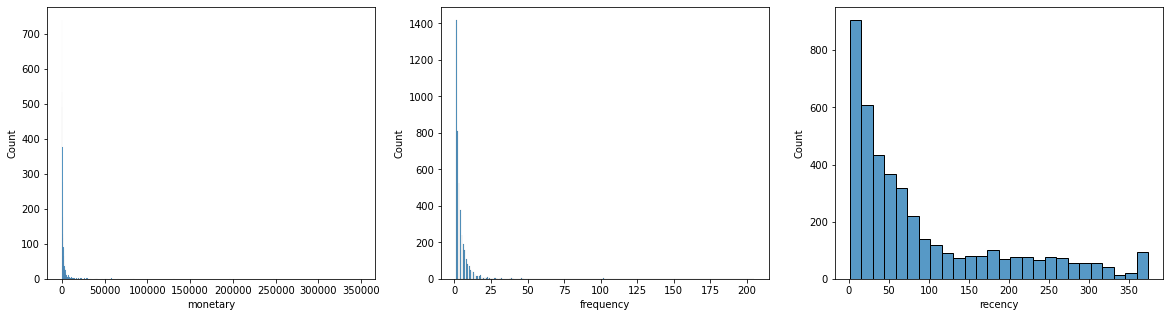

In [34]:
# showing the distribution of rfm metrics
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm_cluster['monetary'])
plt.subplot(1, 3, 2)
sns.histplot(rfm_cluster['frequency'])
plt.subplot(1, 3, 3)
sns.histplot(rfm_cluster['recency'])
plt.show(block=True)

In [35]:
# standardization of the dataframe
mms = MinMaxScaler().fit_transform(rfm_cluster)
rfm_cluster_scaled = pd.DataFrame(mms)
rfm_cluster_scaled.head()

0     1     2
0 0.001 0.049 0.440
1 0.004 0.005 0.005
2 0.001 0.000 0.196
3 0.008 0.010 0.113
4 0.001 0.000 0.027

In [36]:
# get the descriprive statistics of new dataframe
rfm_cluster_scaled.describe().T

count  mean   std   min   25%   50%   75%   max
0 4312.000 0.006 0.026 0.000 0.001 0.002 0.005 1.000
1 4312.000 0.017 0.040 0.000 0.000 0.005 0.020 1.000
2 4312.000 0.242 0.260 0.000 0.046 0.139 0.362 1.000

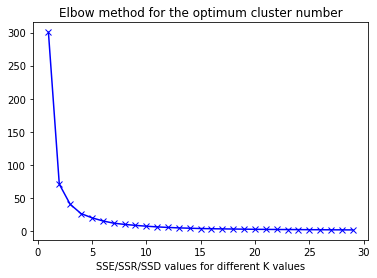

In [37]:
# determination of the optimum cluster number using elbow method
kmeans = KMeans()
ssd = []
K = range(1, 30)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(rfm_cluster_scaled)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('SSE/SSR/SSD values for different K values')
plt.title('Elbow method for the optimum cluster number')
plt.show(block=True)

In [38]:
silhouette_score_list = []
for i in range(2, 10):
    kmeans.fit(rfm_cluster_scaled)
    silhouette_score_list.append(silhouette_score(rfm_cluster_scaled, kmeans.labels_))
    print(silhouette_score_list)

[0.4166452998248639]
[0.4166452998248639, 0.4142694654674208]
[0.4166452998248639, 0.4142694654674208, 0.40754655502134485]
[0.4166452998248639, 0.4142694654674208, 0.40754655502134485, 0.41686649247612734]
[0.4166452998248639, 0.4142694654674208, 0.40754655502134485, 0.41686649247612734, 0.41448329516068794]
[0.4166452998248639, 0.4142694654674208, 0.40754655502134485, 0.41686649247612734, 0.41448329516068794, 0.4270445436837459]
[0.4166452998248639, 0.4142694654674208, 0.40754655502134485, 0.41686649247612734, 0.41448329516068794, 0.4270445436837459, 0.41920698386534894]
[0.4166452998248639, 0.4142694654674208, 0.40754655502134485, 0.41686649247612734, 0.41448329516068794, 0.4270445436837459, 0.41920698386534894, 0.42279231908116244]


In [39]:
# kmeans using 4 clusters and k-means++ initialization
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300)
kmeans.fit(rfm_cluster_scaled)
pred = kmeans.predict(rfm_cluster_scaled)

In [40]:
# dataframe with clustering
dataframe = pd.DataFrame(rfm_cluster)
dataframe['cluster'] = pred
dataframe['cluster'] = dataframe['cluster'] + 1
dataframe.head()

monetary  frequency  recency  cluster
customer id                                       
12346.000     372.860         11      165        2
12347.000    1323.320          2        3        1
12348.000     222.160          1       74        4
12349.000    2671.140          3       43        1
12351.000     300.930          1       11        1

In [41]:
# get the average values of the variables according to the cluster
dataframe.groupby('cluster').mean()

monetary  frequency  recency
cluster                              
1        3257.084      6.655   19.775
2         726.041      2.060  189.074
3         529.113      1.344  307.018
4        1233.742      3.106   78.344

In [42]:
# reaching the average scores and counts of recency, frequency, monetary in those classes
dataframe[['cluster', 'recency', 'frequency', 'monetary']].groupby('cluster').agg(['mean', 'count'])

recency       frequency       monetary      
           mean count      mean count     mean count
cluster                                             
1        19.775  2057     6.655  2057 3257.084  2057
2       189.074   650     2.060   650  726.041   650
3       307.018   454     1.344   454  529.113   454
4        78.344  1151     3.106  1151 1233.742  1151

# **ASSOCIATION ANALYSIS FOR THE COUNTRY UNITED KINGDOM IN THE DATAFRAME**

In [43]:
df = df_.copy()
df.head()
df = df[df['country'] == 'United Kingdom']
df_apriori = df.groupby(['invoice', 'description'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('invoice')
df_apriori.head()

description  21494  22467  22719    DOORMAT UNION JACK GUNS AND ROSES   3 STRIPEY MICE FELTCRAFT   4 PURPLE FLOCK DINNER CANDLES   ANIMAL STICKERS   BLACK PIRATE TREASURE CHEST   BROWN  PIRATE TREASURE CHEST    Bank Charges   CAMPHOR WOOD PORTOBELLO MUSHROOM   CHERRY BLOSSOM  DECORATIVE FLASK   FAIRY CAKE CANDLES   FLAMINGO LIGHTS   HOME SWEET HOME  BLACKBOARD   IVORY PAPER CUP CAKE CASES    LARGE SKULL WINDMILL   NEW BAROQUE BLACK BOXES   OVAL WALL MIRROR DIAMANTE   \
invoice                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
489434       0.000  0.000  0.000                                0.000                      0.000                           0.000             0.000                         0.000                           0.000          0.000                              0.000                              0.000                0.000             0.000                         0.000                         0.000                  0.000                     0.000                        0.000   
489435       0.000  0.000  0.000                                0.000                      0.000                           0.000             0.000                         0.000                           0.000          0.000                              0.000                              0.000                0.000             0.000                         0.000                         0.000                  0.000                     0.000                        0.000   
489436       0.000  0.000  0.000                                0.000                      0.000                           0.000             0.000                         0.000                           0.000          0.000                              0.000                              0.000                0.000             0.000                         0.000                         0.000                  0.000                     0.000                        0.000   
489437       0.000  0.000  0.000                                0.000                      0.000                           0.000             0.000                         0.000                           0.000          0.000                              0.000                              0.000                0.000             0.000                         0.000                         0.000                  0.000                     0.000                        0.000   
489438       0.000  0.000  0.000                                0.000                      0.000                           0.000             0.000                         0.000                           0.000          0.000                              0.000                              0.000                0.000             0.000                         0.000                         0.000                  0.000                     0.000                        0.000   

description   PAINT YOUR OWN CANVAS SET   PEACE WOODEN BLOCK LETTERS   RED/WHITE DOT MINI CASES   RIDGED GLASS T-LIGHT HOLDER   SET 2 TEA TOWELS I LOVE LONDON    SET Of 6 SOLDIER SKITTLES   SILVER CHERRY LIGHTS   SILVER T-LIGHT SETTING   STAR  T-LIGHT HOLDER    VINTAGE DESIGN GIFT TAGS   WHITE BAMBOO RIBS LAMPSHADE   WHITE CHERRY LIGHTS  *Boombox Ipod Classic  *USB Office Glitter Lamp  *USB Office Mirror Ball  10 COLOUR SPACEBOY PEN  11 PC CERAMIC TEA SET POLKADOT  \
invoice                                                                                                                                                                                                          

In [44]:
df_apriori.shape

(23705, 4657)

In [45]:
def num(x):
    if x <= 0:
        return 0
    else:
        return 1

new_df = df_apriori.applymap(num)
new_df.head()

description  21494  22467  22719    DOORMAT UNION JACK GUNS AND ROSES   3 STRIPEY MICE FELTCRAFT   4 PURPLE FLOCK DINNER CANDLES   ANIMAL STICKERS   BLACK PIRATE TREASURE CHEST   BROWN  PIRATE TREASURE CHEST    Bank Charges   CAMPHOR WOOD PORTOBELLO MUSHROOM   CHERRY BLOSSOM  DECORATIVE FLASK   FAIRY CAKE CANDLES   FLAMINGO LIGHTS   HOME SWEET HOME  BLACKBOARD   IVORY PAPER CUP CAKE CASES    LARGE SKULL WINDMILL   NEW BAROQUE BLACK BOXES   OVAL WALL MIRROR DIAMANTE   \
invoice                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
489434           0      0      0                                    0                          0                               0                 0                             0                               0              0                                  0                                  0                    0                 0                             0                             0                      0                         0                            0   
489435           0      0      0                                    0                          0                               0                 0                             0                               0              0                                  0                                  0                    0                 0                             0                             0                      0                         0                            0   
489436           0      0      0                                    0                          0                               0                 0                             0                               0              0                                  0                                  0                    0                 0                             0                             0                      0                         0                            0   
489437           0      0      0                                    0                          0                               0                 0                             0                               0              0                                  0                                  0                    0                 0                             0                             0                      0                         0                            0   
489438           0      0      0                                    0                          0                               0                 0                             0                               0              0                                  0                                  0                    0                 0                             0                             0                      0                         0                            0   

description   PAINT YOUR OWN CANVAS SET   PEACE WOODEN BLOCK LETTERS   RED/WHITE DOT MINI CASES   RIDGED GLASS T-LIGHT HOLDER   SET 2 TEA TOWELS I LOVE LONDON    SET Of 6 SOLDIER SKITTLES   SILVER CHERRY LIGHTS   SILVER T-LIGHT SETTING   STAR  T-LIGHT HOLDER    VINTAGE DESIGN GIFT TAGS   WHITE BAMBOO RIBS LAMPSHADE   WHITE CHERRY LIGHTS  *Boombox Ipod Classic  *USB Office Glitter Lamp  *USB Office Mirror Ball  10 COLOUR SPACEBOY PEN  11 PC CERAMIC TEA SET POLKADOT  \
invoice                                                                                                                                                                                                          

In [46]:
rule_fp = fpgrowth(new_df, min_support=0.02, use_colnames=True)
rule_fp.head()

support                          itemsets
0    0.065  (STRAWBERRY CERAMIC TRINKET BOX)
1    0.056   (ASSORTED COLOUR BIRD ORNAMENT)
2    0.055        (HOME BUILDING BLOCK WORD)
3    0.045        (LOVE BUILDING BLOCK WORD)
4    0.040    (SCOTTIE DOG HOT WATER BOTTLE)

In [47]:
items = apriori(new_df, min_support=0.02, use_colnames=True)
rule = association_rules(items, metric='lift', min_threshold=1)
rule.head()

antecedents                           consequents  antecedent support  consequent support  support  confidence   lift  leverage  conviction
0         (60 TEATIME FAIRY CAKE CASES)  (PACK OF 60 PINK PAISLEY CAKE CASES)               0.051               0.044    0.023       0.440  9.999     0.020       1.707
1  (PACK OF 60 PINK PAISLEY CAKE CASES)         (60 TEATIME FAIRY CAKE CASES)               0.044               0.051    0.023       0.513  9.999     0.020       1.948
2    (PACK OF 72 RETRO SPOT CAKE CASES)         (60 TEATIME FAIRY CAKE CASES)               0.052               0.051    0.023       0.441  8.593     0.020       1.696
3         (60 TEATIME FAIRY CAKE CASES)    (PACK OF 72 RETRO SPOT CAKE CASES)               0.051               0.052    0.023       0.450  8.593     0.020       1.722
4               (HEART OF WICKER LARGE)               (HEART OF WICKER SMALL)               0.046               0.043    0.023       0.504 11.798     0.021       1.929